## Best Subset Selection

#### Installations

In [ ]:
import itertools
import time
from tqdm import trange, tqdm_notebook
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import train_test_split

%matplotlib inline 
plt.style.use('ggplot')

# from google.colab import files
# uploaded = files.upload()

### Data Cleaning and Pre-Processing


In [ ]:
data = pd.read_csv('2012_public_use_data_aug2016.csv')
orig_data = data.copy()
orig_data["TOTAL_EUI"] = orig_data["ELCNS"]/orig_data["SQFT"]


data = data.iloc[:,1:445].copy()
data_extra = orig_data.iloc[:,1093:1103].copy()
data = data.merge(data_extra, how='outer', left_index=True, right_index=True)
data["ELEXP"] = orig_data["ELEXP"].copy()
print("Shape of original data: ", orig_data.shape)
print("Shape of original selected data: ", data.shape)

cat = []
cont = []
keep = []
for col in data.columns:
  temp = keep[:]
  temp.append(col)
  if len(data[data.columns.intersection(temp)].dropna()) <= 3000:
    continue
  keep.append(col)
  if len(data[col].unique()) <= 54:
    cat.append(col)
  else:
    cont.append(col)

data = data[keep].copy()


data["TOTAL_EUI"]= orig_data["TOTAL_EUI"].copy()
data.reset_index()
data = data.dropna()

# # Dropping outliers
# Q1 = data['TOTAL_EUI'].quantile(0.25)
# Q3 = data['TOTAL_EUI'].quantile(0.75)
# IQR = Q3 - Q1
# # Filtering values between Q1-1.5IQR and Q3+1.5IQR
# data = data.query('(@Q1 - 1.5 * @IQR) <= TOTAL_EUI <= (@Q3 + 1.5 * @IQR)')

y = data["TOTAL_EUI"].copy()
data = data.drop("SQFT", axis=1)
data = data.drop("TOTAL_EUI", axis=1)
print("Shape of kept data: ", data.shape)


for feature in cat: 
  data[feature] = data[feature].astype(str)

one_hot = pd.get_dummies(data, prefix=cat)
print("Shape of one-hot-encode: ", one_hot.shape)


Shape of original data:  (6720, 1120)
Shape of original selected data:  (6720, 455)
Shape of kept data:  (3009, 125)
Shape of one-hot-encode:  (3009, 469)


## Feature Selection

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(one_hot, y, test_size = .3, random_state=43)

Cross validation RFE with a DecisionTreeRegressor estimator:

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor

estimator = DecisionTreeRegressor()
selector = RFECV(estimator, cv=5, step=1) #n_features_to_select = 150
selector.fit(x_train, y_train.values.reshape(-1))

RFECV(cv=5, estimator=DecisionTreeRegressor())

In [ ]:
print(f"Optimal number of features: {selector.n_features_}")

Optimal number of features: 314


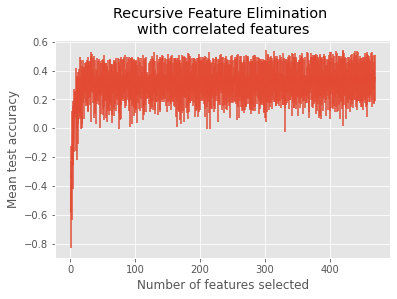

In [ ]:
min_features_to_select = 1
n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores+1),
    selector.cv_results_["mean_test_score"][0:n_scores],
    yerr = selector.cv_results_["std_test_score"][0:n_scores],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## Model Implementation




In [ ]:
from sklearn.pipeline import Pipeline

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
pipeline_rf = Pipeline(steps=[('s',selector),('m',model_rf)])

pipeline_rf.fit(x_train.values, y_train.values.reshape(-1))
pipeline_rf.score(x_test.values, y_test.values.reshape(-1))

0.7244805436891413

In [ ]:
from sklearn.metrics import r2_score
n = selector.transform(x_test.values).shape[0]
f = selector.transform(x_test.values).shape[1]

pred_rf = pipeline_rf.predict(x_test.values)
r2 = r2_score(y_test.values.reshape(-1), pred_rf)
adj_r2 = 1-(1-r2)*(n-1)/(n-f-1)

print('Adjusted_R^2: {:.2f}'.format(adj_r2))
print('R^2: {:.2f}'.format(r2))

Adjusted_R^2: 0.58
R^2: 0.72


**XGBoost**

In [ ]:
from xgboost import XGBRegressor

model_xg = XGBRegressor(n_estimators=1000, max_depth=50, eta=0.1, subsample=0.7, colsample_bytree=0.8)
pipeline_xg = Pipeline(steps=[('s',selector),('m',model_xg)])

pipeline_xg.fit(x_train.values, y_train.values.reshape(-1))
pipeline_xg.score(x_test.values, y_test.values.reshape(-1))


[01:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.7415619206151656

In [ ]:
pred_xg = pipeline_xg.predict(x_test.values)
r2 = r2_score(y_test.values.reshape(-1), pred_xg)
adj_r2 = 1-(1-r2)*(n-1)/(n-f-1)

print('Adjusted_R^2: {:.2f}'.format(adj_r2))
print('R^2: {:.2f}'.format(r2))

Adjusted_R^2: 0.61
R^2: 0.74


CatBoost Model

In [ ]:
# !pip install catboost
# !pip install lightgbm
# !pip install shap

In [ ]:
import catboost as cb 
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [ ]:
train_dataset = cb.Pool(selector.transform(x_train), y_train.values.reshape(-1)) 
test_dataset = cb.Pool(selector.transform(x_test), y_test.values.reshape(-1))

model_cb = cb.CatBoostRegressor(loss_function='RMSE')#, depth=6, l2_leaf_reg=1, iterations=200, learning_rate=0.1)


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [ ]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cb.grid_search(grid, train_dataset)

Streaming output truncated to the last 5000 lines.
156:	learn: 11.3680976	test: 10.7772481	best: 10.7772481 (156)	total: 636ms	remaining: 174ms
157:	learn: 11.3192584	test: 10.7391125	best: 10.7391125 (157)	total: 639ms	remaining: 170ms
158:	learn: 11.2960953	test: 10.7295654	best: 10.7295654 (158)	total: 643ms	remaining: 166ms
159:	learn: 11.2675540	test: 10.7129040	best: 10.7129040 (159)	total: 659ms	remaining: 165ms
160:	learn: 11.2517095	test: 10.7119330	best: 10.7119330 (160)	total: 663ms	remaining: 161ms
161:	learn: 11.2311420	test: 10.7071566	best: 10.7071566 (161)	total: 666ms	remaining: 156ms
162:	learn: 11.2170729	test: 10.7077422	best: 10.7071566 (161)	total: 670ms	remaining: 152ms
163:	learn: 11.1759864	test: 10.6757715	best: 10.6757715 (163)	total: 674ms	remaining: 148ms
164:	learn: 11.1586210	test: 10.6680682	best: 10.6680682 (164)	total: 678ms	remaining: 144ms
165:	learn: 11.1410292	test: 10.6664209	best: 10.6664209 (165)	total: 681ms	remaining: 140ms
166:	learn: 11.1110

{'params': {'depth': 6,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

'best params': {'depth': 6,
  'l2_leaf_reg': 1,
  'iterations': 200,
  'learning_rate': 0.1}

In [ ]:
#model_cb.fit(train_dataset)
pred_cb = model_cb.predict(selector.transform(x_test))
#rmse = (np.sqrt(mean_squared_error(y_test, pred_cb)))
r2 = r2_score(y_test.values.reshape(-1), pred_cb)
adj_r2 = 1-(1-r2)*(n-1)/(n-f-1)
#print('RMSE: {:.2f}'.format(rmse))
print('Adjusted_R^2: {:.2f}'.format(adj_r2))
print('R^2: {:.2f}'.format(r2))

Adjusted_R^2: 0.68
R^2: 0.79


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


**LightGBM Model**

In [ ]:
import lightgbm as lgb

lgb_train = lgb.Dataset(selector.transform(x_train), y_train.values.reshape(-1))
lgb_eval = lgb.Dataset(selector.transform(x_test), y_test.values.reshape(-1), reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 400,
    'learning_rate': 0.06,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train



model_lgb = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])
model_lgb.save_model('model.RFECV')

pred_lgb = model_lgb.predict(selector.transform(x_test.values), num_iteration=model_lgb.best_iteration)
#y_pred_without_RFE = gbm.predict(x_test.values, num_iteration=gbm.best_iteration)





/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


Starting training...
[1]	valid_0's l2: 397.079	valid_0's l1: 12.623
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 370.385	valid_0's l1: 12.1264
[3]	valid_0's l2: 346.994	valid_0's l1: 11.6771
[4]	valid_0's l2: 325.783	valid_0's l1: 11.2484
[5]	valid_0's l2: 303.477	valid_0's l1: 10.826
[6]	valid_0's l2: 286.038	valid_0's l1: 10.4402
[7]	valid_0's l2: 272.7	valid_0's l1: 10.1324
[8]	valid_0's l2: 259.783	valid_0's l1: 9.82996
[9]	valid_0's l2: 248.085	valid_0's l1: 9.57848
[10]	valid_0's l2: 238.827	valid_0's l1: 9.34226
[11]	valid_0's l2: 230.852	valid_0's l1: 9.14765
[12]	valid_0's l2: 221.079	valid_0's l1: 8.91888
[13]	valid_0's l2: 213.036	valid_0's l1: 8.72674
[14]	valid_0's l2: 205.628	valid_0's l1: 8.53358
[15]	valid_0's l2: 200.201	valid_0's l1: 8.35921
[16]	valid_0's l2: 193.28	valid_0's l1: 8.18687
[17]	valid_0's l2: 187.55	valid_0's l1: 8.04076
[18]	valid_0's l2: 181.421	valid_0's l1: 7.86637
[19]	valid_0's l2: 176.685	valid_0's l1: 7.72794
[2

In [ ]:
#rmse_test = mean_squared_error(y_test.values.reshape(-1), y_pred, squared=False)
r2 = r2_score(y_test.values.reshape(-1), pred_lgb)
adj_r2 = 1-(1-r2)*(n-1)/(n-f-1)
#print(f'The RMSE of prediction is: {rmse_test}')
print('R2: {:.2f}'.format(r2))
print('Adjusted_R^2: {:.2f}'.format(adj_r2))

R2: 0.74
Adjusted_R^2: 0.60


SHAP Plots for all models

In [ ]:
import shap

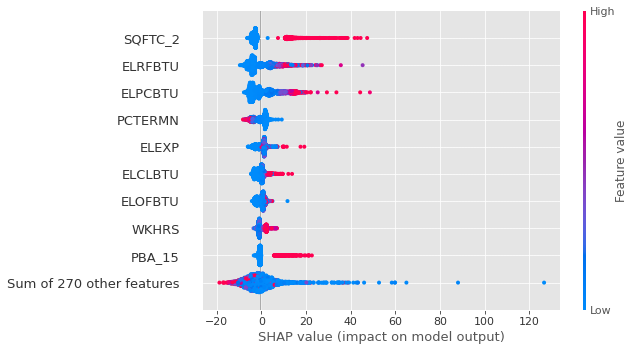

In [ ]:
explainer_cb = shap.Explainer(model_cb)
mask_cb=selector.support_
screen_cb = x_train.columns[mask_cb]
shap_values_cb = explainer_cb(x_train[screen_cb])
shap.plots.beeswarm(shap_values_cb)

# explainer = shap.Explainer(model.predict, X_test)
# # Calculates the SHAP values - It takes some time
# shap_values = explainer(X_test)

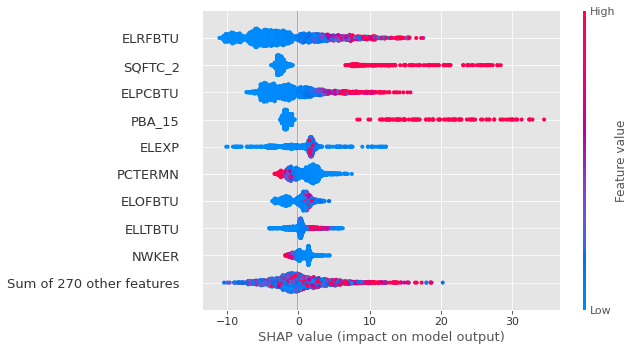

In [ ]:
explainer_lgb = shap.TreeExplainer(model_lgb)
mask_lgb=selector.support_
screen_lgb = x_train.columns[mask_lgb]
shap_values_lgb = explainer_lgb(x_train[screen_lgb])
shap.plots.beeswarm(shap_values_lgb)

## Scratch Work







In [ ]:
# from numpy import mean
# from numpy import std
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold

# model = RandomForestRegressor()
# pipeline = Pipeline(steps=[('s',selector),('m',model)])

# cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# n_scores = cross_val_score(pipeline, x_train.values, y_train.values.reshape(-1), scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
# from yellowbrick.model_selection import RFECV as YRFECV
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error, make_scorer

# estimator = DecisionTreeRegressor()
# scorer = make_scorer(mean_squared_error, squared=False)
# visualizer = YRFECV(estimator, step=1, cv=5, scoring=scorer)
# visualizer.fit(x_train.values, y_train.values.reshape(-1))

In [ ]:
# import sklearn.metrics

# #!pip install auto-sklearn
# import autosklearn.regression
# import matplotlib.pyplot as plt
# automl = autosklearn.regression.AutoSklearnRegressor(
#     time_left_for_this_task=120,
#     per_run_time_limit=30,
# )
# automl.fit(x_train.values, y_train.values.reshape(-1), dataset_name="energy_data")

In [ ]:
# print(automl.leaderboard())

In [ ]:
# test_predictions = automl.predict(x_test.values)
# print("Test R2 score:", sklearn.metrics.r2_score(y_test.values.reshape(-1), test_predictions))

In [ ]:
# from sklearn.feature_selection import RFECV
# from sklearn.tree import DecisionTreeRegressor


# estimator = DecisionTreeRegressor()
# selector = RFECV(estimator, step=1, cv=5)
# selector.fit(x_train.values, y_train.values.reshape(-1))

In [ ]:
# pd.set_option('display.max_columns', None)
# # Took you dataset cleaning work Kal. Don't know if you mind
# train_data = pd.read_csv('2012_public_use_data_aug2016.csv')




#                             # Continoues variables
# train_data = train_data[['ELCNS', 'SQFT', 'NFLOOR', 'YRCON', 'WKHRS', 'NWKER', 'HEATP', 'COOLP', 'PCTERMN', 'LAPTPN', 'PRNTRN', 'COPIERN', 'LTOHRP', 'LTNHRP', 'DAYLTP',
#                             # Categorical
#                             'OPEN24', 'OPNWE', 'PBAPLUS', 'RENRFF', 'RENINS', 'CENDIV', 'PBA', 'FREESTN', 'RFTILT', 'WLCNS', 
#                             'BLDSHP', 'BLDSHP', 'YRCONC', 'RENHVC', 'RENWIN', 'RENLGT', 'RENELC', 'RENINS', 'RENSTR']]

# # Drop rows with NA values
# train_data = train_data.dropna()

# # Create Total EUI
# train_data['TOTAL_EUI'] = train_data['ELCNS']/train_data['SQFT']

# Q1 = train_data['TOTAL_EUI'].quantile(0.25)
# Q3 = train_data['TOTAL_EUI'].quantile(0.75)
# IQR = Q3 - Q1

# # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
# train_data = train_data.query('(@Q1 - 1.5 * @IQR) <= TOTAL_EUI <= (@Q3 + 1.5 * @IQR)')

# y = train_data['TOTAL_EUI']

# # Remove explanatory variables from train and test datasets
# train_data = train_data.drop("SQFT", axis=1)
# train_data = train_data.drop("ELCNS", axis=1)
# train_data = train_data.drop("TOTAL_EUI", axis=1)

# train_data = train_data.reset_index()
# cat_features = ['OPEN24', 'OPNWE', 'PBAPLUS', 'RENRFF', 'RENINS', 'CENDIV', 'PBA', 'FREESTN', 'RFTILT', 
#                 'WLCNS','BLDSHP', 'BLDSHP', 'YRCONC', 'RENHVC', 'RENWIN', 'RENLGT', 'RENELC', 'RENINS', 'RENSTR']
# cont_features = ['ELCNS', 'SQFT', 'NFLOOR', 'YRCON', 'WKHRS', 'NWKER', 'HEATP', 'COOLP', 'PCTERMN', 'LAPTPN', 'PRNTRN', 'COPIERN', 'LTOHRP', 'LTNHRP', 'DAYLTP']

# for feature in cat_features: 
#   train_data[feature] = train_data[feature].astype(str)

# one_hot = pd.get_dummies(train_data, prefix=cat_features)
